# Beer Recommenders

The purpose of this notebook is to explore the Beer Advocate review data and the possibility of a recommendation engine. First, data exploration, then model experimentation.

Based on the nature of the data, three different recommenders will be touched on:

- Content Based Recommender - using review text, apply NLP methods to determine similarity of beers with reviewers' descriptors of the beers.

- Collaborative Filter - using scored review data, determine beers that are close in rating to the user's input.

- Hybrid Recommender - a mix of the content based and collaborative recommenders, using the text data from the reviews and the scores entered by other users.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

In [3]:
#upload the datasets from local files
beers = pd.read_csv(r'F:\Datasets\beers.csv')
breweries = pd.read_csv(r'F:\Datasets\breweries.csv')
reviews = pd.read_csv(r'F:\Datasets\reviews.csv')

## Data Discovery

In [3]:
beers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358873 entries, 0 to 358872
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            358873 non-null  int64  
 1   name          358873 non-null  object 
 2   brewery_id    358873 non-null  int64  
 3   state         298147 non-null  object 
 4   country       358719 non-null  object 
 5   style         358872 non-null  object 
 6   availability  358873 non-null  object 
 7   abv           320076 non-null  float64
 8   notes         358827 non-null  object 
 9   retired       358873 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 27.4+ MB


The beers dataset has almost 360000 rows and includes features such as an id number, the name of the beer, the brewery id number, state it originated from, the country, style, availability, abv, notes and whether the beer is retired or not. Breweries tend to launch and retire beers often, especially one off blends and specialty beers.

In [4]:
breweries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50347 entries, 0 to 50346
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50347 non-null  int64 
 1   name     50347 non-null  object
 2   city     50289 non-null  object
 3   state    39076 non-null  object
 4   country  50341 non-null  object
 5   notes    50262 non-null  object
 6   types    50347 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.7+ MB


The breweries dataset contains over 50,000 rows and contains some basic information like the name, city, state, and country. It also contains a "notes" feature and "types" feature. The types feature tells us what sort of establishment the beer comes from ie restaurant, pub, or brewery. For this project, we will only focus on the origins of the beers, the brewery.

In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073128 entries, 0 to 9073127
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   date      object 
 3   text      object 
 4   look      float64
 5   smell     float64
 6   taste     float64
 7   feel      float64
 8   overall   float64
 9   score     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 692.2+ MB


The reviews dataset is where the bulk of this recommendation system will take information from. It contains numerical data regarding look, smell, taste, feel and overall scores for the beer as given by the consumer. It also contains a text review (for most beers), the date in which the review was written, the username of the person leaving the review and the unique beer id number. 

In [6]:
#how many unique beers are in the beers dataset?
beers['id'].nunique()

358873

In [4]:
#rename 'id' to 'beer_id' to avoid any confusion later
beers = beers.rename(columns={'id':'beer_id'})

#rename the id column as brewery_id so we can merge dataframes appropriately
breweries = breweries.rename(columns={'id':'brewery_id'})

We have over 350,000 unique beers by id number in this dataset. In other words, we have plenty of beers to drink... I mean... work with.

In [8]:
breweries['types'].unique()

array(['Brewery', 'Brewery, Bar, Beer-to-go', 'Bar, Eatery', 'Store',
       'Bar, Beer-to-go', 'Brewery, Bar, Eatery, Beer-to-go',
       'Brewery, Bar, Eatery', 'Bar', 'Brewery, Eatery', 'Brewery, Bar',
       'Eatery', 'Brewery, Beer-to-go', 'Eatery, Beer-to-go',
       'Homebrew, Beer-to-go', 'Bar, Eatery, Beer-to-go', 'Homebrew',
       'Brewery, Bar, Homebrew, Beer-to-go', 'Brewery, Homebrew',
       'Brewery, Homebrew, Beer-to-go', 'Bar, Homebrew, Beer-to-go',
       'Brewery, Bar, Eatery, Homebrew, Beer-to-go',
       'Brewery, Eatery, Beer-to-go', 'Brewery, Bar, Homebrew',
       'Brewery, Bar, Eatery, Homebrew',
       'Bar, Eatery, Homebrew, Beer-to-go', 'Brewery, Eatery, Homebrew',
       'Brewery, Eatery, Homebrew, Beer-to-go', 'Bar, Homebrew',
       'Bar, Eatery, Homebrew', 'Eatery, Homebrew, Beer-to-go'],
      dtype=object)

We can see that the dataset contains many 'types' of breweries. When digging into the data further, this is just a tag that BeerAdvocate uses to bin establishments that make the beer. This feature shouldn't have an impact on our models.

In [10]:
print('Start date', reviews['date'].min())
print('End date', reviews['date'].max())
print('Unique beers reviewed', reviews['beer_id'].nunique())
print('Total number of unique reviewers', reviews['username'].nunique())

Start date 1996-08-22
End date 2018-09-30
Unique beers reviewed 309542
Total number of unique reviewers 164934


The reviews dataset is a wealth of information containing reviews from 1996 through 2018, with 309542 unique beers reviewed by almost 165,000 different reviewers. This is going to be fun.

In [11]:
#statistical preview of the reviews dataset
reviews.describe()

,beer_id,look,smell,taste,feel,overall,score
count,9.073128e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,5.283110e+06,9.073128e+06
mean,7.730655e+04,3.952155e+00,3.887863e+00,3.920704e+00,3.884350e+00,3.916280e+00,3.889815e+00
std,7.929345e+04,5.517191e-01,6.115910e-01,6.333365e-01,5.999279e-01,6.054554e-01,6.127417e-01
min,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.155400e+04,3.750000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.570000e+00
50%,5.654500e+04,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
75%,1.076670e+05,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00,4.250000e+00
max,3.731280e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


Each of the beers are rated on look, smell, taste, feel, overall and a final category named score. The score column is used by Beer Advocate to calculate a final score for the beer based on all reviews. 

Based on the median and mean scores given, it seems as if people enjoy leaving reviews more when they like a beer rather than when they dislike a beer. 

## Data Cleaning

In [5]:
#search for null values
print('Beers Dataset Nulls')
print(beers.isnull().sum())
print('--------------')
print('Breweries Dataset Nulls')
print(breweries.isnull().sum())
print('--------------')
print('Reviews Dataset Nulls')
print(reviews.isnull().sum())

Beers Dataset Nulls
beer_id             0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64
--------------
Breweries Dataset Nulls
brewery_id        0
name              0
city             58
state         11271
country           6
notes            85
types             0
dtype: int64
--------------
Reviews Dataset Nulls
beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64


Since we're building our recommendation engine from reviews, we need to drop the null values from the reviews dataset. 

In [7]:
#drop null values in reviews dataset
reviews = reviews.dropna()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5281976 entries, 3816851 to 2897762
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   beer_id   int64  
 1   username  object 
 2   date      object 
 3   text      object 
 4   look      float64
 5   smell     float64
 6   taste     float64
 7   feel      float64
 8   overall   float64
 9   score     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 443.3+ MB


After dropping the nulls, we still have roughly 5.3 million reviews to work with. This should be plenty to build a decent a recommender system. 

In [8]:
#reviewers have left reviews for certain beers more than once, lets only keep their highest score for the beers they have reviewed more than once
#in the words of David Portnoy "one bite, everybody knows the rules"

reviews = reviews.sort_values('overall', ascending=False).drop_duplicates(subset=['username', 'beer_id'], keep='first')

In [9]:
#let's go ahead and merge the beers and reviews datasets by beer_id
beer_reviews = pd.merge(reviews, beers, on='beer_id')
#rename the 'name' column to 'beer_name' to avoid confusion
beer_reviews = beer_reviews.rename(columns={'name':'beer_name'})

beer_reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,beer_name,brewery_id,state,country,style,availability,abv,notes,retired
0,66815,Hefewiseman,2018-02-14,,5.0,5.0,5.0,5.00,5.0,5.00,Art,22511,VT,US,Belgian Saison,Rotating,6.5,Art is the wine barrel fermented and aged vers...,f
1,66815,celeriac,2011-05-01,"Incredible beer. Opens with a big hiss, and...",4.5,5.0,5.0,4.50,5.0,4.92,Art,22511,VT,US,Belgian Saison,Rotating,6.5,Art is the wine barrel fermented and aged vers...,f
2,66815,TurdFurgison,2012-01-28,I picked up a few bottles of this last year...,4.5,5.0,5.0,4.00,5.0,4.87,Art,22511,VT,US,Belgian Saison,Rotating,6.5,Art is the wine barrel fermented and aged vers...,f
3,66815,coz,2017-03-25,,4.5,5.0,5.0,4.75,5.0,4.95,Art,22511,VT,US,Belgian Saison,Rotating,6.5,Art is the wine barrel fermented and aged vers...,f
4,66815,jkrug5,2017-02-19,,5.0,5.0,5.0,5.00,5.0,5.00,Art,22511,VT,US,Belgian Saison,Rotating,6.5,Art is the wine barrel fermented and aged vers...,f


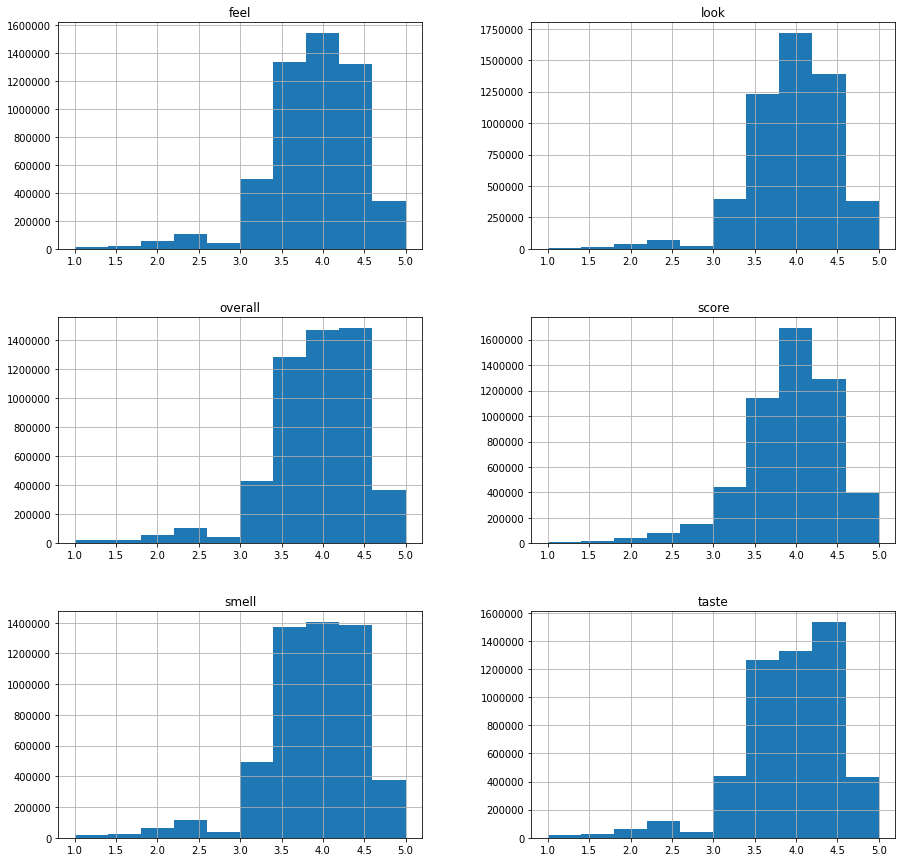

In [18]:
#score distributions
beer_reviews[['feel', 'look', 'overall', 'score', 'smell', 'taste']].hist(figsize=(15,15))
plt.show()

All the score distributions look fairly similar and most scores land in the 4.0 range. This visual is showing me that most people take the time to leave a review when they enjoy the beer rather than leaving a review when they hate it. This is somewhat surprising to me given how much people love to complain with their keyboards. 

---

# Exploratory Data Analysis

## Reviewers/Users

In [19]:
#group the reviews by username in a new column called "user_count"
reviews['review_count'] = reviews['username'].groupby(reviews['username']).transform('count')

#check it out
reviews.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,review_count
2300609,115317,KrajDoesBeer,2015-04-17,10.24 batch. citra all in the nose.. some d...,5.0,5.0,5.0,4.75,5.0,4.98,351
8041686,47019,Kwright,2018-07-19,,5.0,5.0,5.0,5.00,5.0,5.00,355
2867438,49789,Kisejohn,2012-07-19,"Aroma: Wow, huge grapefruit citrus and pin...",4.5,5.0,5.0,4.50,5.0,4.92,25
5065844,5441,HombreWing,2007-10-22,Eyes: Deep orange...bright ...huge billowin...,4.5,4.0,4.0,4.50,5.0,4.28,43
6570103,139521,PC_Principal,2017-02-03,,5.0,5.0,5.0,5.00,5.0,5.00,343


In [20]:
#create column containing average review score left by each user
reviews['avg_score'] = reviews['score'].groupby(reviews['username']).transform('mean')

Text(0.5,1,'User Review Plot')

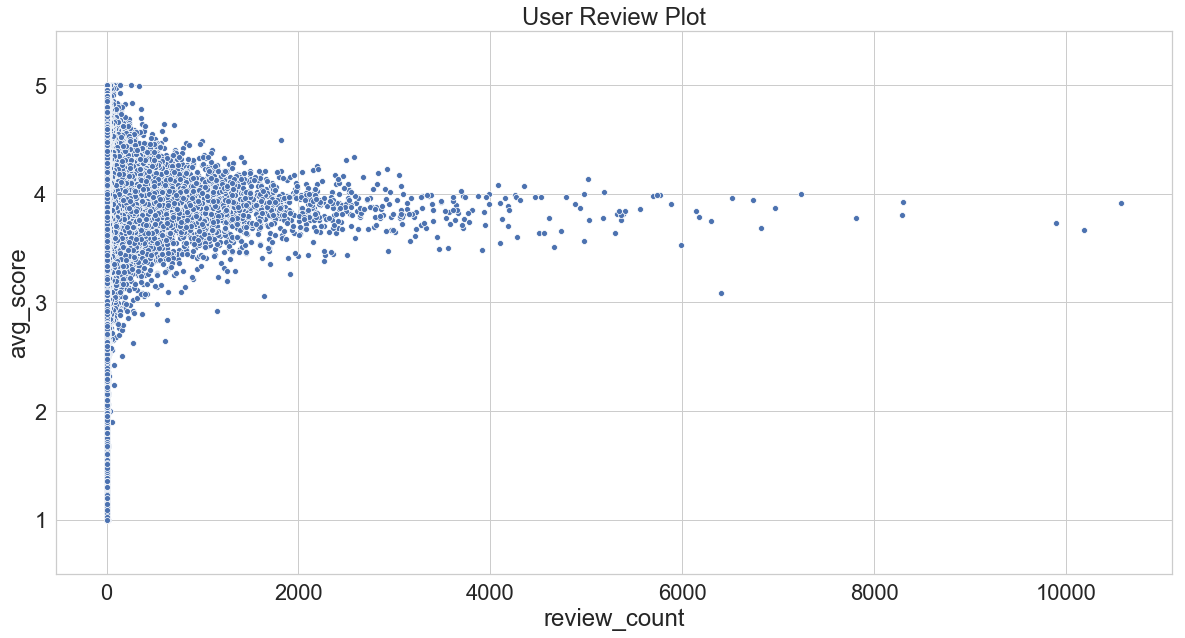

In [21]:
#create variable with dropped duplicates of usernames, ie, each row will be a unique username
reviews_v2 = reviews.drop_duplicates('username')

#build a scatterplot representing each user's average score vs review count
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.set_style("whitegrid")
ax = sns.scatterplot(x='review_count', y='avg_score', data=reviews_v2)
ax.set(ylim=(0.5, 5.5))
plt.title('User Review Plot')

In the above plot, each dot represents a unique username in the dataset, the y axis represents the average scores given by that user and the x axis represents the total number of reviews that user has given. From the plot, we can see that most users stick to scores between three and four(ish). As stated earlier, it seems that reviewers like to publish reviews when they like the beer, not when they dislike it. Take a look at the lower average scores, these reviewers haven't left much at all.

Notice some of the outliers in the data, our top reviewer has over 10,000 reviews!

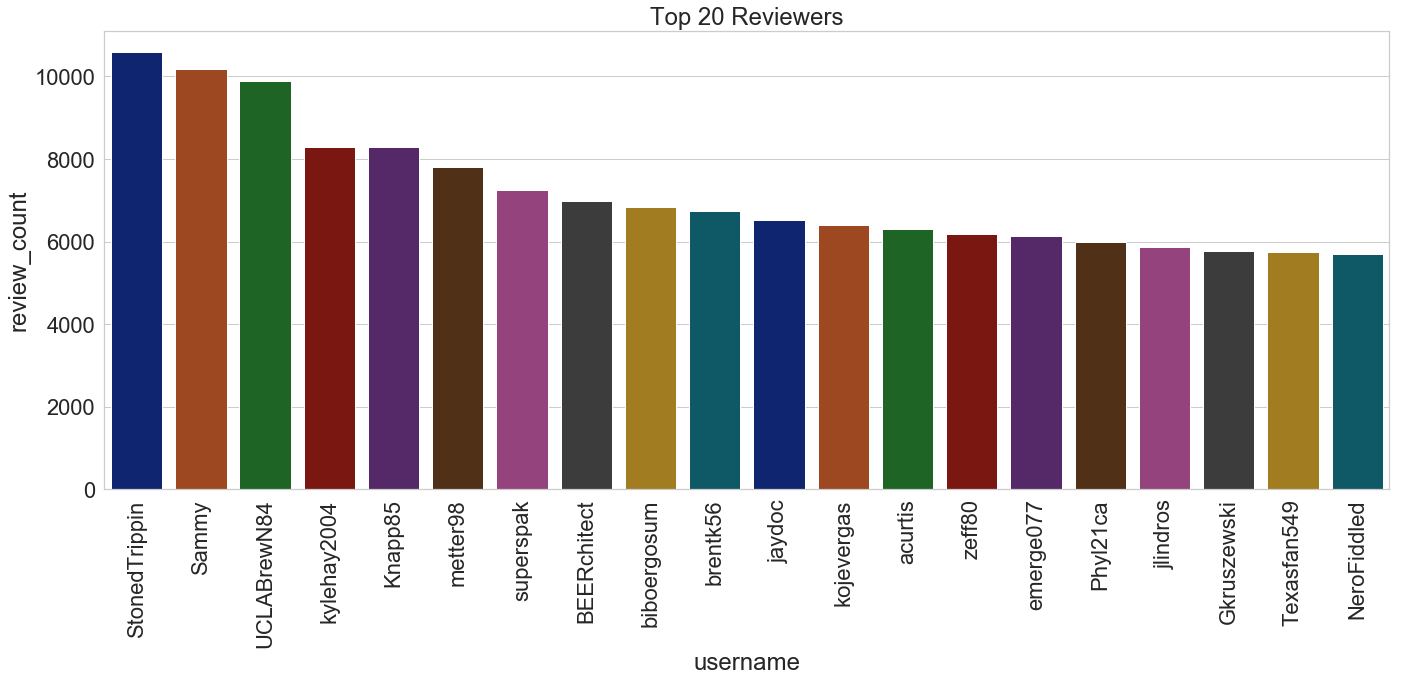

In [22]:
#build a df with the top 20 reviewers by review count
top_20 = reviews.drop_duplicates('review_count').sort_values(by=['review_count'], ascending=False).head(20)

#plot the top 20 reviewers
plt.figure(figsize=(20,10))
ax = sns.barplot(x='username', y="review_count", data=top_20, palette='dark')
plt.title('Top 20 Reviewers')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Ah, yes, StonedTrippin leads the pack in BeerAdvocate reviews...

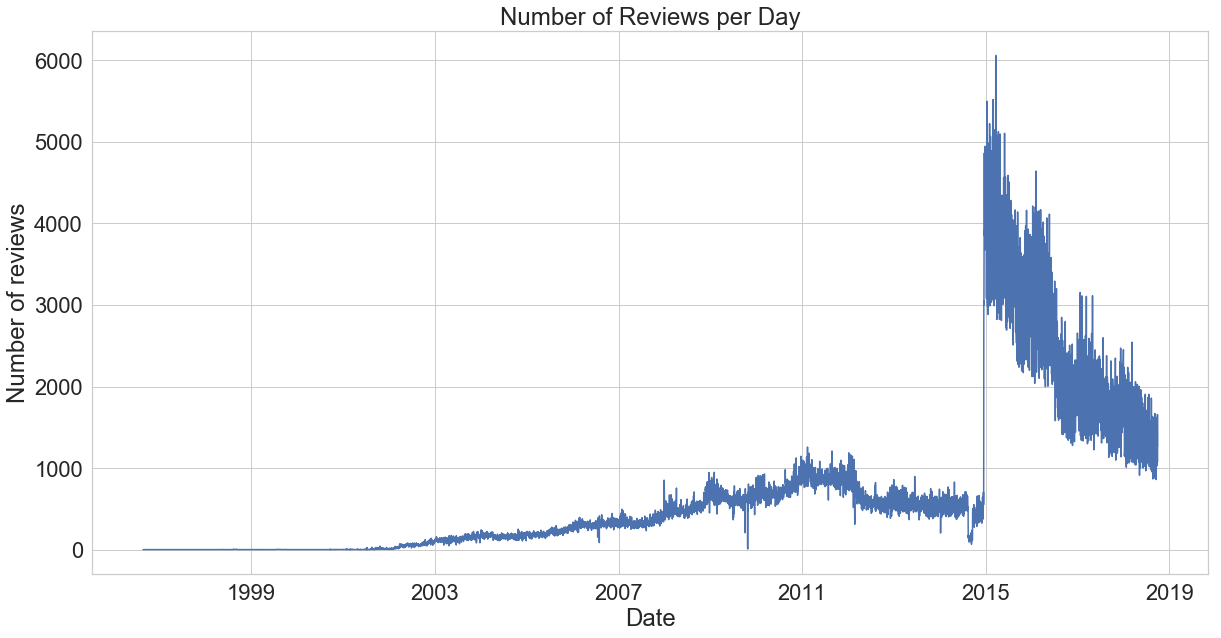

In [23]:
#convert the date column to a format pandas can recognize
reviews['date'] = pd.to_datetime(reviews['date'])

#group the reviews by review date
group_by_date = reviews[['date']].groupby(reviews['date'].dt.date).agg(['count'])

#plot reviews per day
plt.figure(figsize = (20, 10))
plt.plot(group_by_date)
plt.xlabel('Date')
plt.ylabel('Number of reviews')
plt.title('Number of Reviews per Day')
plt.show()

This is an interesting picture. We can see a massive spike in reviews per day in 2015. While this may just be an anomaly in the data, it does line up with the craft beer craze explosion. 

## Beer Analysis

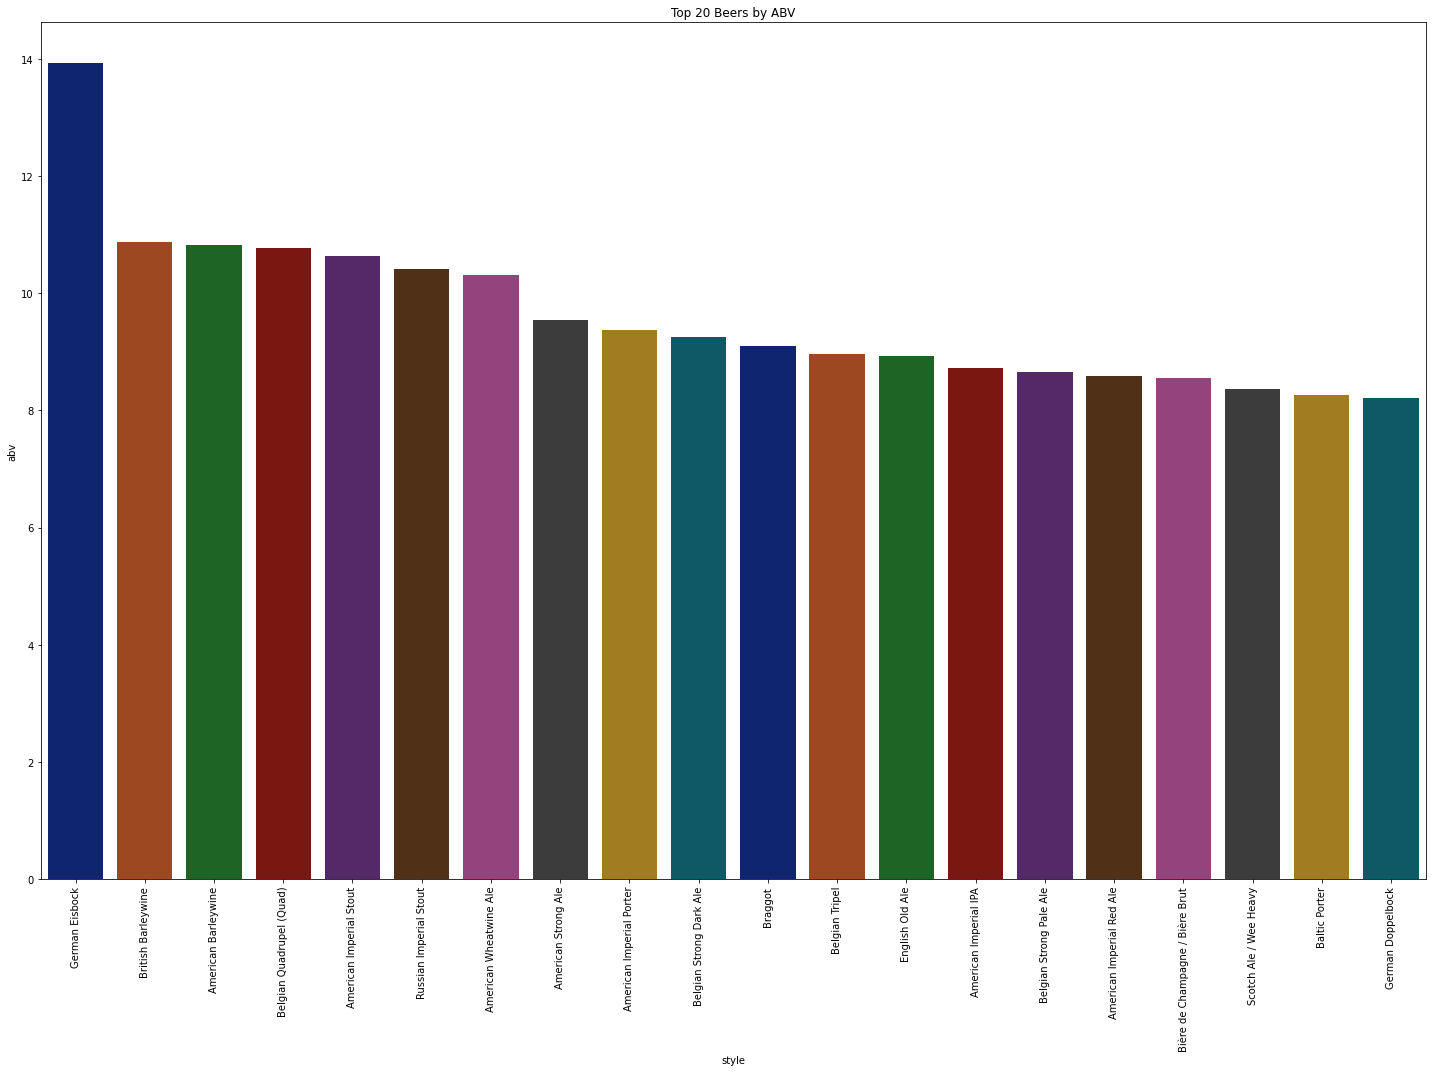

In [10]:
#plot the booziest styles of beer by average abv value
alcohol = beers.groupby('style')['abv'].mean().nlargest(20).reset_index()
alcohol = pd.DataFrame(alcohol)

#plot the top 20 beers by ABV
plt.figure(figsize=(20,15))
ax = sns.barplot(x='style', y='abv', data=alcohol, palette='dark')
plt.title('Top 20 Beers by ABV')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

It's no surprise that the German Eisbock is the highest ABV beer in the dataset. It's actually really interesting how this beer is brewed, it is freeze concentrated in multiple steps to get the alcohol content as high as possible. It typically ranges from 9% to 14% in alcohol content but some breweries such as Sam Adams and BrewDog have pushed the style to well over 30% alcohol. 

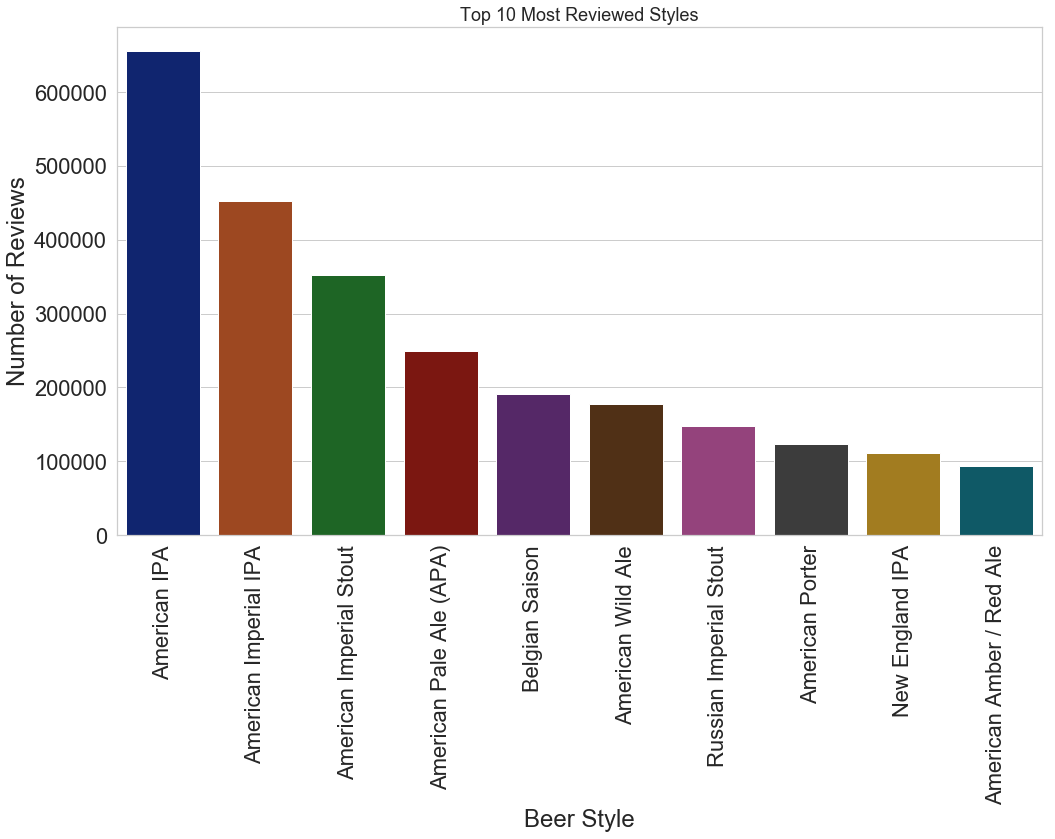

In [25]:
#group the styles by review count to reveal the most popular styles
beer_reviews['style_count'] = beer_reviews['style'].groupby(beer_reviews['style']).transform('count')

#create a df with the top 10 most reviewed styles
top_10 = beer_reviews.drop_duplicates('style_count').sort_values(by=['style_count'], ascending=False).head(10)

#plot the top 10 most reviewed styles
plt.figure(figsize=(15,12))
ax = sns.barplot(x='style', y='style_count', data=top_10, palette='dark')
sns.set(font_scale=1.5)
plt.title('Top 10 Most Reviewed Styles')
plt.ylabel('Number of Reviews')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

It's no surprise that American IPA's and Imperial IPA's are the most reviewed styles on Beer Advocate. Although, it is interesting that American Wild Ale is in the top 10. These are the most popular craft beer styles in the world. Every brewery has a flagship IPA on tap at any time. 

Imperial Stouts are another popular category that most breweries will have on their menu. They tend to fall into the specialty release category for most breweries as they can be costly to brew. Many breweries across the US host festivals for the release of this style such as Goose Island's Bourbon County Stout or Cigar City's Hunahpu's Imperial Stout.

American pale ale is a classic style and is possibly the style that started the "Craft Beer Revolution". Sierra Nevada was one of the orginal craft breweries and Ken Grossman, the owner, brewed the famous Sierra Nevada Pale Ale on a homemade system that he still uses to this day.

The Belgian Saison is an old farmhouse style ale that was brewed at warmer temperatures in the good ol' days. In today's industry they vary wildly from brewery to brewery and many brewers add interesting flavors to the style. At Cigar City for example, they added cucumber to the beer which won them a Great American Beer Festival medal.

It's surprising to see the Wild Ale on this list as it is such a new category. Wild Ales will typically use yeast strains harvested from the "wild". These tend to be sour in taste and contain some whacky ingredients. They're not my thing, but as we can see, a lot of people like them.

The Russian Imperial Stout is basically the same as the American Imperial Stout. Some brewers argue there is a difference between the two, but ultimately, they're just strong, roasty, chocolatey, delcious beers.

It warms my heart that the American Porter made this list, it is one of my favorite styles and it has become a forgotten style with the popularity of the stout. Porters and stouts are fairly similar but Porters lack the harsh roasty note that Stouts contain. 

The New England IPA is very similar to the American IPA but it'll be more hazy in appearance and will have a juicy like hop character. They're a fairly new trend that's caught on recently.

The American Amber and Red Ale are daker ales, not quite as dark as the porter or stout but more red in color. They tend to have strong caramel notes and they vary in hoppy-ness and bitterness. 

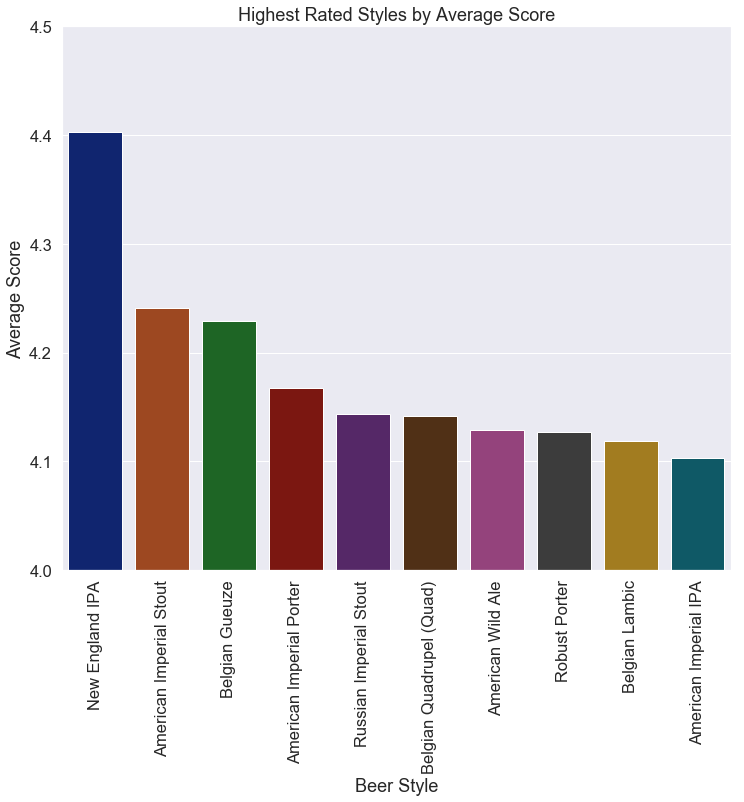

In [27]:
#plot the highest rated styles (by average score)
highest = beer_reviews.groupby('style')['overall'].mean().nlargest(10).reset_index()
highest = pd.DataFrame(highest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='style', y='overall', data=highest, palette='dark')
plt.title('Highest Rated Styles by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)
plt.ylim(4,4.5)
plt.show()

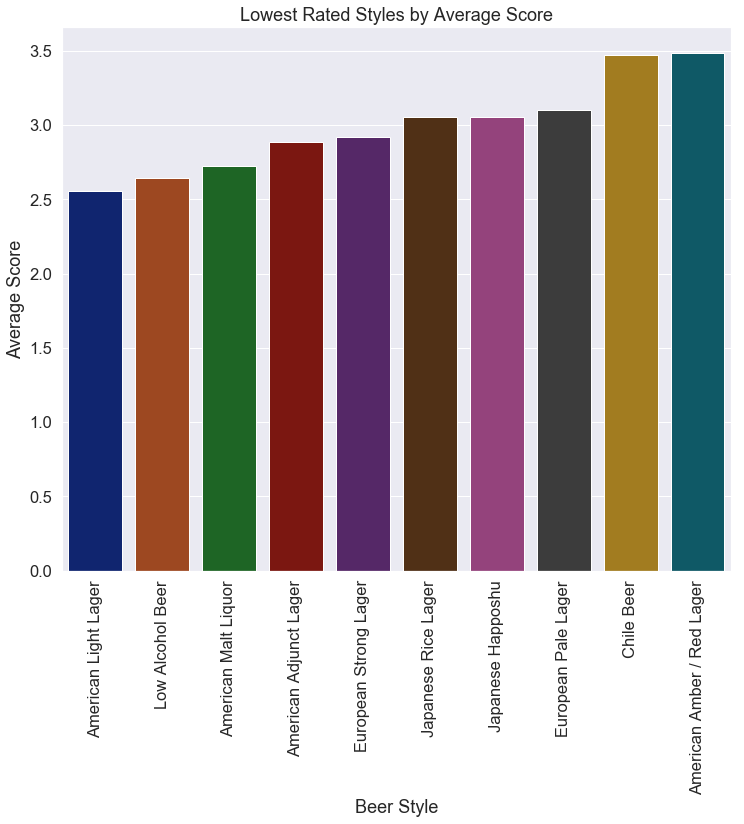

In [28]:
#plot the lowest rated styles (by average score)
lowest = beer_reviews.groupby('style')['overall'].mean().nsmallest(10).reset_index()
lowest = pd.DataFrame(lowest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='style', y='overall', data=lowest, palette='dark')
plt.title('Lowest Rated Styles by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)
plt.show()

## Breweries

In [12]:
#unique breweries
print('Unique Breweries count: ')
breweries['name'].nunique()

Unique Breweries count: 


45245

In [13]:
#how many breweries from each country?
print('Breweries per Country: ')
breweries['country'].value_counts()

Breweries per Country: 


US    34693
GB     2525
CA     1890
DE     1812
BE      756
      ...  
SC        1
ST        1
SN        1
SB        1
VC        1
Name: country, Length: 199, dtype: int64

This data is most represented by the US and Great Britain - two countries with amazing brewing traditions. While the USA focuses more on pushing the boundaries of brewing, the Brits have a more delicate, traditional style of brewing. It's interesting to track the trends between the two countries as they intertwine with each other. It was only recently that an American style of brewing was seen in Great Britain, and vice versa, the session style ales which originated in Britain are now making their way over to the US. 

In [14]:
#unique countries
print('Unique countries: ')
breweries['country'].unique()

Unique countries: 


array(['BE', 'US', 'GB', 'AU', 'IT', 'CA', 'GR', 'FR', 'AT', 'ES', 'RU',
       'SE', 'NL', 'UZ', 'CO', 'JP', 'PL', 'CZ', 'DE', 'PT', 'DK', 'TW',
       'AR', 'NZ', 'CH', 'BR', 'MX', 'VN', 'FI', 'EE', 'PR', 'UA', 'IM',
       'SM', 'CL', 'BZ', 'AL', 'SK', 'IE', 'CN', 'KY', 'PW', 'NO', 'RO',
       'MM', 'SG', 'LT', 'RS', 'BM', 'KH', 'LV', 'HK', 'CY', 'MD', 'IS',
       'PH', 'IN', 'PE', 'UY', 'TR', 'TH', 'IR', 'JM', 'EC', 'ZA', 'KR',
       'BG', 'IL', 'LI', 'HU', 'NG', 'CR', 'VI', 'PS', 'KP', 'MY', 'KG',
       'GT', 'CG', 'KE', 'MK', 'FO', 'AE', 'TD', 'WS', 'JE', 'LA', 'BB',
       'TO', 'MN', 'ER', 'DO', 'VU', 'MG', 'GE', 'VE', 'BY', 'SI', 'CK',
       'SV', 'MU', 'ID', 'BH', 'VC', 'SR', 'NE', 'MZ', 'LU', 'RW', 'UG',
       'MT', 'HR', 'GG', 'NC', 'ME', 'PA', 'PF', 'BA', 'TM', 'SN', 'DZ',
       'ET', 'AO', 'GH', 'NP', 'MA', 'BS', 'BT', 'OM', 'KZ', 'CW', 'CU',
       'AG', nan, 'BF', 'GF', 'AZ', 'HT', 'GL', 'LB', 'DM', 'HN', 'VG',
       'CI', 'GP', 'TC', 'NI', 'BO', 'AM', 'SX', 'GI

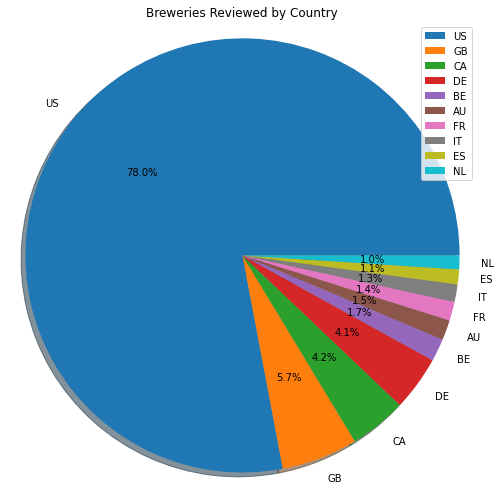

In [15]:
#let's make a visualization showing the distribution of countries in the dataset
df_breweries = breweries[['country', 'name']]
pie_data = df_breweries.groupby('country').count().reset_index()
asc_pie_data = pie_data.sort_values(by='name', ascending=False).head(10)

#plot the number of breweries reviewed by country
countries = asc_pie_data['country']
locations = asc_pie_data['name']

plt.figure(figsize=(7,7))
plt.pie(locations, shadow=True, labels=countries, autopct='%.1f%%')
plt.legend(countries, loc='best')
plt.axis('equal')
plt.title('Breweries Reviewed by Country')

plt.tight_layout()
plt.show()

There is quite a wide representation of countries within this dataset. As mentioned before, the US and Great Britain are the top brewing countries within the data. This makes sense as the US and Great Britain LOVE beer. It's not surprising to see Germany (DE) in the top three as Germany has a rich history of beer brewing. It is somewhat surprising to see France as a top producing country. France is known for its wine, not beer, BUT France does have a rich brewing history. 

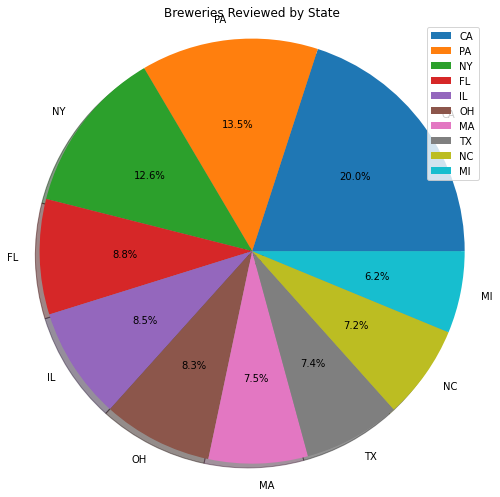

In [16]:
#filter for us breweries only
us_breweries = breweries.loc[breweries['country']=='US']

#let's make a visualization showing the top breweries reviewed by state
states = us_breweries[['state', 'name']]
pie_data = us_breweries.groupby('state').count().reset_index()
asc_pie_data = pie_data.sort_values(by='name', ascending=False).head(10)

#plot the number of breweries reviewed by country
state = asc_pie_data['state']
name = asc_pie_data['name']

plt.figure(figsize=(7,7))
plt.pie(name, shadow=True, labels=state, autopct='%.1f%%')
plt.legend(state, loc='best')
plt.axis('equal')
plt.title('Breweries Reviewed by State')

plt.tight_layout()
plt.show()

California is the most popular state for brewery reviews followed by Pennsylvania, New York, Florida, and Illinois. California is a beer mecca, so it's not at all surprising that it is the number 1 state for brewery reviews. I'm somewhat surprised that Colorado nor Oregon are in the top 10 states for brewery reviews. 

In [17]:
#how many unique U.S. breweries in the dataset?
print('Unique U.S. breweries: ')
us_breweries['name'].nunique() 

Unique U.S. breweries: 


30185

In [ ]:
# make a US brewery reviews dataframe
us_brewery_reviews = pd.merge(beer_reviews, us_breweries , on='brewery_id')

# rename columns
us_brewery_reviews = us_brewery_reviews.rename(columns={'name':'brewery_name', 'notes_x':'beer_notes', 
                                                        'notes_y':'brewery_notes', 'state_x':'state',
                                                       'country_x':'country'})
# drop unneeded columns
us_brewery_reviews = us_brewery_reviews.drop(['state_y', 'country_y', 'style_count'], axis=1)

# for the recommendation engine, we don't need retired beers in the dataset, lets get rid of those
us_brewery_reviews = us_brewery_reviews.loc[us_brewery_reviews['retired'] == 'f']

# find the most reviewed breweries in the US
us_brewery_reviews['count'] = us_brewery_reviews['brewery_id'].groupby(us_brewery_reviews['brewery_id']).transform('count')

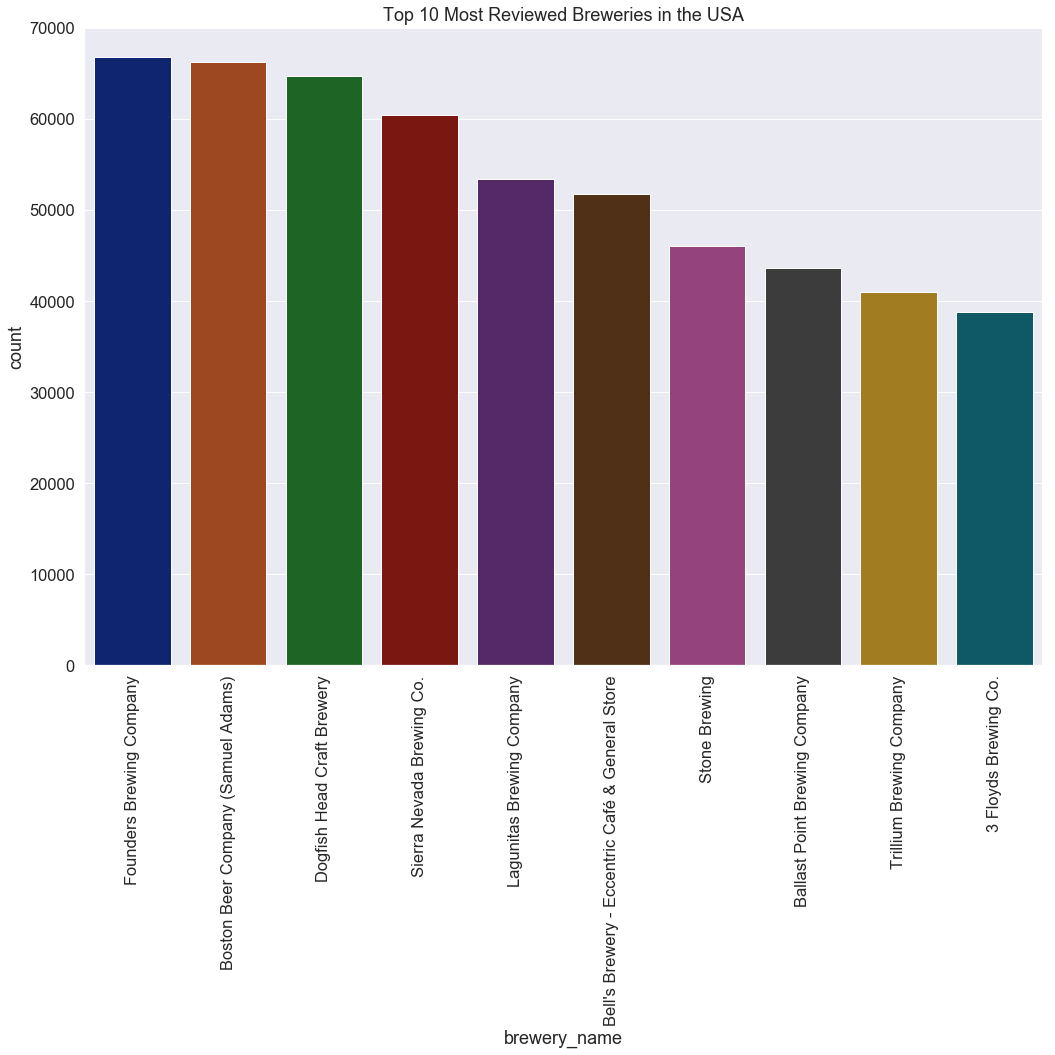

In [36]:
# top 10 breweries by review count data
top_10_breweries_usa = us_brewery_reviews.drop_duplicates('count').sort_values(by=['count'], ascending=False).head(10)

# plot the top 10 most reviewed breweries
plt.figure(figsize=(15,15))
ax = sns.barplot(x='brewery_name', y='count', data=top_10_breweries_usa, palette='dark')
plt.title('Top 10 Most Reviewed Breweries in the USA')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

The graph above says a lot. Founders Brewing Company out of Michigan is the most reviewed brewery on Beer Advocate while Sam Adams is number two. Both breweries have quality options and a wide distribution reach but Sam Adams has about 10x the production output as Founder's. 

Dogfish Head as made famous by Sam Calagione has been a staple craft brand for years. They're known for consistency and quality. Sierra Nevada Brewing, my personal favorite, brews the best beer in the world. Lagunitas, which is California based, recently built a massive brewery in Chicago to increase their distribution.

Bell's Brewery is also a Michigan based brewery and brews one of my personal favorites, Two Hearted Ale. Stone Brewing is out of California and is known for beers like Enjoy By IPA and Arrogant Bastard Ale. Ballast Point, also out of California, is known for some bold flavors and brews one of the most popular IPA's in the USA, Sculpin.

Trillium Brewing is out of Boston and is known for high quality options. Three Floyds is out of Indiana and was made famous by a beer called Zombie Dust.

## Data Prep

In [37]:
#drop unneeded columns
us_brewery_reviews = us_brewery_reviews.drop(['count'], axis=1)

In [38]:
#any null values?
us_brewery_reviews.isnull().sum()

beer_id              0
username             0
date                 0
text                 0
look                 0
smell                0
taste                0
feel                 0
overall              0
score                0
beer_name            0
brewery_id           0
state            17767
country           4335
style                0
availability         0
abv              41553
beer_notes        1225
retired              0
brewery_name         0
city             17767
brewery_notes     2154
types                0
dtype: int64

Need to keep in mind that text cells that are empty are not being recognized as null values.

In [39]:
#empty text cells are not being recognized as null, lets fix this
us_brewery_reviews['text']= us_brewery_reviews['text'].str.strip().replace('',np.nan)
us_brewery_reviews.isnull().sum()

beer_id                0
username               0
date                   0
text             1773090
look                   0
smell                  0
taste                  0
feel                   0
overall                0
score                  0
beer_name              0
brewery_id             0
state              17767
country             4335
style                  0
availability           0
abv                41553
beer_notes          1225
retired                0
brewery_name           0
city               17767
brewery_notes       2154
types                  0
dtype: int64

Ah hah, there they are... let's drop all reviews with no text.

In [41]:
#drop all reviews with no text column content
us_brewery_reviews = us_brewery_reviews.dropna(axis=0, subset=['text'])

We still have some null values showing but we don't need to worry about them. Location data won't be needed, and brewery/beer notes are general info regarding the breweries and beers in the dataset that we will not use. For this recommender we will focus on the consumer's ratings and text reviews.

## Beer Review Text Cleaning

In [43]:
#define lemmatizer
lemmatizer = WordNetLemmatizer()

#remove stopwords
stop = stopwords.words('english')
us_brewery_reviews['without_stopwords']  = us_brewery_reviews['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#lemmatize/tokenize/make everything lowercase/remove punctuation
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['without_stopwords'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

#remove digitsvb
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['lemmatized_text'].str.replace('\d+', '')

#add some more stopwords
newStopWords = ['beer', 'one', 'would', 'get', 'come', 'also', 'oz', 'could']
stop.extend(newStopWords)
us_brewery_reviews['lemmatized_text'] = us_brewery_reviews['lemmatized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#save prepped dataframe locally
us_brewery_reviews.to_csv(r'F:\Datasets\us_brewery_reviews.csv')

In [18]:
us_reviews = pd.read_csv(r'F:\Datasets\us_brewery_reviews.csv')

In [19]:
#to fight against users having too much power over a single beer, lets limit the beers to have at least 10 reviews
#no need for the "unnamed" column
us_reviews = us_reviews.drop(['Unnamed: 0'], axis=1)

#count the beer_id's, choose the most popular beers to be in the dataframe
us_reviews['review_count'] = us_reviews['beer_id'].groupby(us_reviews['beer_id']).transform('count')

#how many unique beers will there be in the dataset when we cut off the threshold at 10 reviews?
us_reviews = us_reviews[us_reviews.review_count >= 10]

#get info and find how many unique beers there are
print('Unique beers present when filtering ')
print('to beers with at least 10 reviews: ')
us_reviews['beer_id'].nunique()

Unique beers present when filtering 
to beers with at least 10 reviews: 


16536

In [12]:
us_reviews['Name'] = us_reviews['brewery_name'].str.cat(us_reviews['beer_name'],sep=', ')

us_reviews['lemmatized_text'] = us_reviews['lemmatized_text'].astype('str')

stop = stopwords.words('english')

# add some more stopwords
newStopWords = ['lager', 'porter', 'stout', 'brewery', 'ale', 'apa', 'ipa', 'ipas', 'belgian', 'red', 'brown', 'cream', 'black', 'amber',
               'golden', 'much', 'year', 'worth', 'english', 'german', 'american', 'stuff', 'pilsner', 'old', 'barleywine',
               'ri', 'imperial', 'non', 'dipa', 'iipa', 'dipas', 'pils', 'pilsener', 'sam', 'irish', 'brewpub', 'st',
               'adam', 'ml', 'tripel', 'quad', 'pa', 'ibu', 'ibus', 'series', 'bell', 'belgium', 'boston', 'city', 'coors',
               'dead', 'dfh', 'dog', 'dogfish', 'founder', 'im', 'imo', 'lagunitas', 'left', 'nevada', 'rogue', 'samuel', 'sierra',
               'southern']
stop.extend(newStopWords)
us_reviews['lemmatized_text'] = us_reviews['lemmatized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [13]:
# warning: this code block takes rouhgly two hours to run
import nltk
from nltk import word_tokenize, pos_tag

us_reviews['lemmatized_text'] = us_reviews['lemmatized_text'].astype('str')

def nouns_adj(text):
    #Given a string of text, tokenize the text and pull out only the nouns and adjectives.
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

us_reviews['adjectives/nouns'] = us_reviews['lemmatized_text'].apply(nouns_adj)
us_reviews = us_reviews.dropna()
us_reviews.to_csv(r'F:\Datasets\us_reviews_base.csv')

In [2]:
us_reviews = pd.read_csv(r'F:\Datasets\us_reviews_base.csv')

---

### Content Recommender

In [3]:
#create new dataframe
beer_text = us_reviews[['beer_id', 'beer_name', 'style', 'brewery_name', 'Name', 'lemmatized_text', 'adjectives/nouns']]

#drop null values
beer_text = us_reviews.dropna(axis=0, subset=['adjectives/nouns'])

#group by beer, think of each beer as a "document"
grouped_beer_text = beer_text.groupby(['beer_id', 'brewery_name', 'beer_name', 'Name', 'style'])['adjectives/nouns'].agg(lambda col: ''.join(col))

#df
beer_text = pd.DataFrame(grouped_beer_text)
beer_text = beer_text.reset_index()

In [27]:
beer_text = pd.read_csv(r'F:\Datasets\beer_text4.csv')

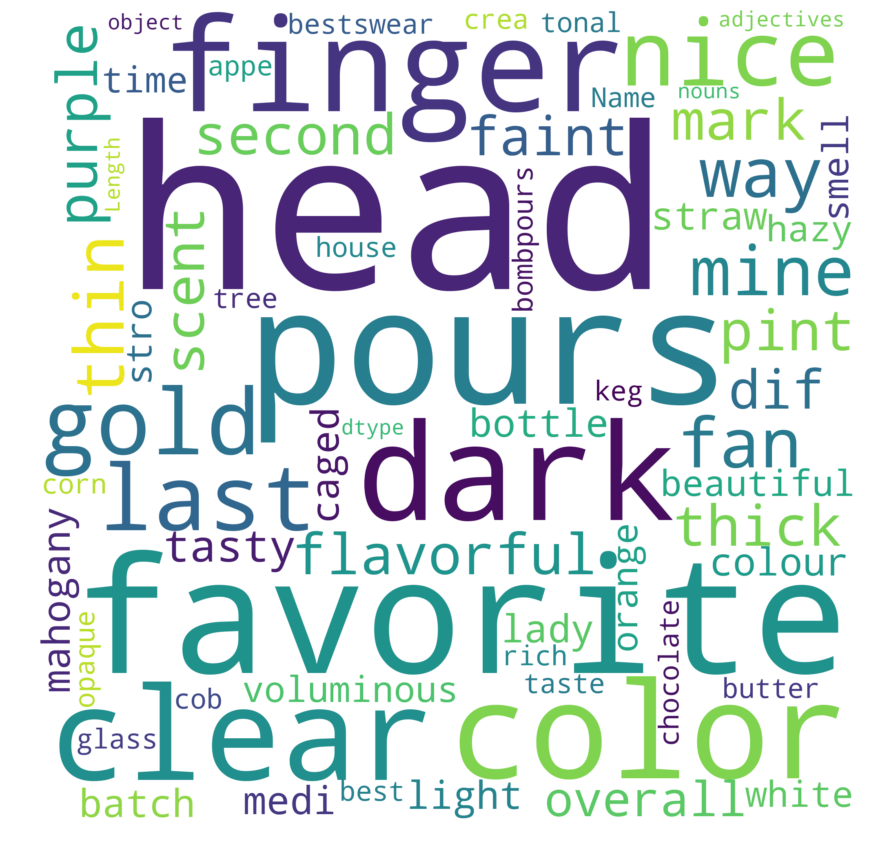

In [24]:
#re visualize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 

other_stopwords_to_remove = ['\\n', 'n', '\\', '>', 'nLines', 'nI',"n'"]
STOPWORDS = STOPWORDS.union(set(other_stopwords_to_remove))
stopwords_a = set(STOPWORDS)
text = str(beer_text['adjectives/nouns'])
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                max_words=200,
                stopwords = stopwords_a, 
                min_font_size = 10).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Another good visual for the portfolio page. This graphic represents the text as a whole in the dataset describing beer across all styles. 

In [28]:
# using lemmatized_text, create the corpus
corpus = beer_text['adjectives/nouns']

# FEATURE EXTRACTION via tfidf vectorizer
tfidf_model = TfidfVectorizer(max_features=500,
                             max_df=0.25,
                             min_df=0.01)

tfidf_matrix = tfidf_model.fit_transform(corpus).todense()
print('The shape of the matrix is:', tfidf_matrix.shape)
tfidf_df = pd.DataFrame(tfidf_matrix)
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

The shape of the matrix is: (15893, 500)


,accent,acid,actual,adequate,adjunct,airy,alcoholic,allspice,almond,alot,...,wispy,wit,witbier,wonder,worse,worthy,yeah,yellowish,yes,yield
0,0.034884,0.000000,0.012685,0.049477,0.013282,0.025558,0.012496,0.000000,0.041679,0.012608,...,0.023271,0.016050,0.000000,0.024601,0.013811,0.024327,0.026381,0.000000,0.012865,0.011725
1,0.028922,0.013288,0.018931,0.024612,0.013214,0.019071,0.049729,0.000000,0.082932,0.062716,...,0.028941,0.007984,0.000000,0.006119,0.006870,0.042355,0.019685,0.000000,0.006400,0.052492
2,0.003524,0.003238,0.003844,0.000000,0.012880,0.003872,0.003029,0.000000,0.000000,0.008405,...,0.003526,0.001945,0.002302,0.002982,0.007533,0.000000,0.005596,0.006994,0.002339,0.002842
3,0.023432,0.000000,0.000000,0.024925,0.240888,0.000000,0.000000,0.000000,0.000000,0.025406,...,0.046894,0.000000,0.000000,0.000000,0.055661,0.024511,0.026581,0.051678,0.000000,0.023627
4,0.013572,0.005196,0.004935,0.014437,0.000000,0.014915,0.087507,0.048041,0.032430,0.019620,...,0.004527,0.018732,0.022168,0.014357,0.005373,0.023661,0.000000,0.000000,0.010010,0.022807


In [26]:
list(tfidf_df.columns.values)

['accent',
 'acid',
 'actual',
 'adequate',
 'adjunct',
 'airy',
 'alcoholic',
 'allspice',
 'almond',
 'alot',
 'anise',
 'anyone',
 'appreciate',
 'aromatics',
 'artificial',
 'atop',
 'attempt',
 'attention',
 'baker',
 'barnyard',
 'basic',
 'bastard',
 'bat',
 'bean',
 'become',
 'becomes',
 'begin',
 'beneath',
 'beverage',
 'biggest',
 'blackberry',
 'bland',
 'blanket',
 'blast',
 'blonde',
 'blood',
 'blue',
 'blueberry',
 'bock',
 'bodied',
 'bomber',
 'book',
 'booziness',
 'bouquet',
 'bourbon',
 'boy',
 'brandy',
 'break',
 'breakfast',
 'brett',
 'brief',
 'brilliant',
 'bring',
 'bronze',
 'brother',
 'brownish',
 'bubblegum',
 'build',
 'bunch',
 'burn',
 'burst',
 'butter',
 'butterscotch',
 'cake',
 'candi',
 'cant',
 'care',
 'carmel',
 'carry',
 'cascade',
 'cask',
 'cellar',
 'certain',
 'chalice',
 'champagne',
 'char',
 'charcoal',
 'cheap',
 'check',
 'cheer',
 'cheese',
 'chestnut',
 'chili',
 'chill',
 'chocolatey',
 'chocolaty',
 'christmas',
 'chunk',
 'chun

In [29]:
#getting close - looks like we may need to eliminate the style names from the vocabulary
df = pd.merge(beer_text, tfidf_df, left_index=True, right_index=True)
df2 = df.groupby(df.columns[4])[df.columns[6:]].mean()

n = 10
df3 = pd.DataFrame(df2.columns[df2.values.argsort(1)[:,-n+9:1:-1]], 
                               index=df2.index)

df3 = df3.rename(columns = lambda x: 'Top_{}'.format(x + 1))
df3 = df3.iloc[:, 0:10]

In [32]:
pd.set_option('display.max_rows', None)
df3

,Top_1,Top_2,Top_3,Top_4,Top_5,Top_6,Top_7,Top_8,Top_9,Top_10
style,,,,,,,,,,
American Adjunct Lager,corn,adjunct,macro,cheap,ice,rice,bland,offensive,worse,mass
American Amber / Red Ale,rye,carmel,nuttiness,coppery,bland,mahogany,toasted,brownish,bomber,cascade
American Amber / Red Lager,macro,corn,adjunct,product,noble,bland,bock,winter,rice,crust
American Barleywine,bourbon,fig,plum,vintage,mahogany,prune,cellar,sipper,whiskey,maple
American Black Ale,char,roasted,mocha,roastiness,licorice,pitch,cola,smoky,mahogany,smoke
American Blonde Ale,blonde,corn,macro,adjunct,bland,noble,graininess,basic,crackery,weather
American Brett,brett,wild,barnyard,saison,lactic,whiskey,raspberry,funkiness,vinegar,horse
American Brown Ale,nuttiness,mahogany,maple,hazelnut,chestnut,cola,bourbon,roasted,pecan,bean
American Brut IPA,dankness,cask,pleasure,courtesy,noble,needle,crackery,grassiness,actual,beneath


This looks pretty damn good coming from the top 10 descriptors of each style of beer. They all make sense from a domain expert perspective. This will be a solid TFIDF matrix to work with in designing the first iteration of the recommender. This will be a great visual for the portfolio site.

In [49]:
#calculate the cosine similarity of the matrix
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse mapping of indices and beer names, and drop duplicate names, if any
indices = pd.Series(beer_text.index, index=beer_text['Name']).drop_duplicates()
#indices = pd.Series(beer_text.index, index=beer_text[['brewery_name', 'beer_name']]).drop_duplicates()

#beer_text = beer_text.set_index(['brewery_name', 'beer_name'])
#indices = beer_text.index.drop_duplicates()

In [5]:
# Function that takes in beer name as input and gives recommendations 
def content_recommender(title, cosine_sim=cosine_sim, df=beer_text, indices=indices):
    # Obtain the index of the beer that matches the name
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    beer_indices = [i[0] for i in sim_scores]

    
    return beer_text[['style', 'brewery_name', 'beer_name']].iloc[beer_indices]

In [12]:
content_recommender("Founders Brewing Company, KBS (Kentucky Breakfast Stout)")

,style,brewery_name,beer_name
8422,American Imperial Stout,Weyerbacher Brewing Co.,Sunday Morning Stout
1741,American Imperial Stout,Goose Island Beer Co.,Bourbon County Brand Stout
3480,American Imperial Stout,Bell's Brewery - Eccentric Café & General Store,Black Note Stout
3769,American Imperial Stout,Central Waters Brewing Co.,Brewer's Reserve Peruvian Morning
5354,American Imperial Stout,Goose Island Beer Co.,Bourbon County Brand Coffee Stout
6353,Russian Imperial Stout,Thirsty Dog Brewing Company,Bourbon Barrel Aged Siberian Night Imperial Stout
3059,American Imperial Stout,Voodoo Brewery,Black Magick
2104,American Imperial Stout,Central Waters Brewing Co.,Brewer's Reserve Bourbon Barrel Stout
4415,Russian Imperial Stout,Full Sail Brewery & Tasting Room & Pub,Black Gold Imperial Stout - Bourbon Barrel Age...
7140,American Imperial Stout,Allentown Brew Works,Fegley's Bourbon Barrel Aged Insidious


---

### Collaborative Filter Recommender

In [2]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF 
from surprise import SlopeOne, CoClustering
from surprise import accuracy

In [3]:
us_reviews = pd.read_csv(r'F:\Datasets\us_reviews_base.csv')

In [4]:
#define the reader
reader = Reader()

#bring in necessary features from beer_200 dataframe
us_reviews_collab = us_reviews[['beer_id', 'username', 'brewery_name', 'beer_name', 'Name', 'score']]

In [5]:
#define the reader
reader = Reader()

#bring in necessary features from beer_200 dataframe
us_reviews_collab = us_reviews[['beer_id', 'username', 'brewery_name', 'beer_name', 'Name', 'score']]

# unique usernames
us_reviews_collab['username'].nunique()

65487

In [5]:
# count the reviews left by users
us_reviews_collab['user_count'] = us_reviews_collab['username'].groupby(us_reviews_collab['username']).transform('count')

# filter out those users who have not left at least 10 reviews
us_reviews_collab = us_reviews_collab[us_reviews_collab.user_count >= 10]
us_reviews_collab['username'].nunique()

14257

In [6]:
# what is the shape of the dataset?
us_reviews_collab.shape

(1407025, 7)

In [7]:
# take a random subset of the data for model testing

us_reviews_collab_sample = us_reviews_collab.sample(frac=0.05, random_state=1)
us_reviews_collab_sample.shape

(70351, 7)

In [8]:
# load the data for Surprise
data = Dataset.load_from_df(us_reviews_collab_sample[['username', 'beer_id', 'score']], reader)

##### K Nearest Neighbors

In [16]:
# Use the KNN algorithm
knn = KNNBasic()

# Run 5-fold cross-validation and then print results
knn_res = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5410  0.5482  0.5369  0.5458  0.5361  0.5416  0.0048  
MAE (testset)     0.3994  0.4011  0.3947  0.4006  0.3928  0.3977  0.0034  
Fit time          2.92    2.77    2.45    2.53    2.46    2.63    0.19    
Test time         0.51    0.44    0.50    0.46    0.46    0.47    0.03    


##### SVD

In [15]:
# Use the SVD algorithm
svd = SVD()

# Run 5-fold cross-validation and then print results
svd_res = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4661  0.4645  0.4675  0.4604  0.4670  0.4651  0.0026  
MAE (testset)     0.3383  0.3394  0.3419  0.3378  0.3407  0.3396  0.0015  
Fit time          3.44    3.44    3.49    3.81    3.69    3.57    0.15    
Test time         0.09    0.12    0.10    0.11    0.11    0.10    0.01    


##### KNN w/ Means

In [17]:
# Use the KNN algorithm
knn_wm = KNNWithMeans()

# Run 5-fold cross-validation and then print results
knn_wm_res = cross_validate(knn_wm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5532  0.5606  0.5582  0.5571  0.5616  0.5582  0.0029  
MAE (testset)     0.4041  0.4080  0.4061  0.4065  0.4098  0.4069  0.0019  
Fit time          2.47    2.65    2.48    2.62    2.56    2.56    0.07    
Test time         0.45    0.45    0.74    0.44    0.78    0.57    0.15    


In [18]:
# tune the SVD model hyperparameters

n_epochs = [60, 90, 120]
n_factors = [300, 450, 500]
lr_all = [0.002, 0.005, 0.007]
reg_all = [0.01, 0.05, 0.1]


param_grid = {'n_epochs': n_epochs,
               'n_factors': n_factors,
               'lr_all': lr_all,
               'reg_all': reg_all} 

svd_tune = GridSearchCV(SVD, param_grid, measures = ['rmse', 'mae'],
                                cv = 3, joblib_verbose=5, n_jobs=-1)
svd_tune.fit(data)

#this code takes freakin' forever to run... run on a random subset of the data to speed it up

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 29.4min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 61.5min finished


In [19]:
# best parameters from SVD tuning
svd_tune.best_params

{'rmse': {'n_epochs': 120, 'n_factors': 300, 'lr_all': 0.007, 'reg_all': 0.1},
 'mae': {'n_epochs': 120, 'n_factors': 300, 'lr_all': 0.007, 'reg_all': 0.1}}

In [24]:
# metrics for tuned SVD model
svd_tune.best_score

{'rmse': 0.4550663952583543, 'mae': 0.3307456505242526}

In [26]:
# extended results for tuned SVD
svd_tune.cv_results

{'split0_test_rmse': array([0.4946176 , 0.48842129, 0.48287771, 0.48841008, 0.47475064,
        0.46761016, 0.48842307, 0.47091116, 0.46428972, 0.51127202,
        0.50133547, 0.49228844, 0.50287174, 0.48599248, 0.47430153,
        0.50209436, 0.47857312, 0.46939885, 0.51727404, 0.50210416,
        0.49526256, 0.50779665, 0.48793207, 0.477512  , 0.50621701,
        0.483687  , 0.47173939, 0.49179539, 0.48091234, 0.47515945,
        0.48534595, 0.46934014, 0.46238529, 0.48285533, 0.46658146,
        0.45999494, 0.50916591, 0.49340473, 0.48335107, 0.501009  ,
        0.4790358 , 0.46815605, 0.4974342 , 0.47336516, 0.46443547,
        0.51314008, 0.4983144 , 0.4871033 , 0.50556147, 0.48169569,
        0.47121552, 0.50143881, 0.47481996, 0.46565772, 0.49081621,
        0.47678906, 0.47059694, 0.48414159, 0.46579978, 0.46070558,
        0.48200201, 0.46387543, 0.45818156, 0.50579408, 0.48907905,
        0.48032694, 0.49713259, 0.4741583 , 0.46535764, 0.49465211,
        0.46891593, 0.461843

In [9]:
# Use the SVD algorithm
svd_best = SVD(n_epochs=120, n_factors=300, lr_all=0.007, reg_all=0.1, random_state=13)

svd_best_res = cross_validate(svd_best, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4461  0.4531  0.4514  0.4555  0.4493  0.4511  0.0032  
MAE (testset)     0.3255  0.3266  0.3269  0.3294  0.3281  0.3273  0.0013  
Fit time          84.36   81.17   75.68   80.69   87.89   81.96   4.06    
Test time         0.25    0.12    0.13    0.19    0.12    0.16    0.05    


In [31]:
# user id: 46
# beer id: 5121

svd_best.predict(46, 5121, 4)

Prediction(uid=46, iid=5121, r_ui=4, est=3.879644995646844, details={'was_impossible': False})

---

### Hybrid Recommender

In [53]:
#create user_id codes
us_reviews_collab.username = pd.Categorical(us_reviews_collab.username)
us_reviews_collab['user_id'] = us_reviews_collab.username.cat.codes

#beer id df to extract from
beer_ids = us_reviews_collab[['Name', 'beer_id', 'username', 'brewery_name']]

#drop duplicates
beer_ids = beer_ids.drop_duplicates(subset=['Name', 'beer_id'], keep='first')

#reset index
beer_ids = beer_ids.reset_index()

#rename columns
beer_ids = beer_ids.rename(columns={'index': 'id'})

beer_ids.head()

,id,Name,beer_id,username,brewery_name
0,0,"Maine Beer Company, Dinner",115317,KrajDoesBeer,Maine Beer Company
1,362,"Maine Beer Company, Lunch",68916,120minuteman,Maine Beer Company
2,1304,"Maine Beer Company, A Tiny Beautiful Something",113339,NMA,Maine Beer Company
3,1537,"Maine Beer Company, Woods & Waters",250469,ThePold,Maine Beer Company
4,1618,"Maine Beer Company, Hop Program - Beer I",156584,golfwolf,Maine Beer Company


In [54]:
#build the beer id map
id_map = beer_ids
id_to_name = id_map.set_index('id')
name_to_id = id_map.set_index('Name')

#define user_id
user_id = us_reviews_collab['user_id']

#indices = pd.Series(us_reviews_collab.index, index=us_reviews_collab['beer_name']).drop_duplicates()

In [55]:
#write function for the hybrid recommender
def hybrid(user_id, title):
    idx = indices[title]
    
    #define the beer map
    tnid = name_to_id.loc[title]['beer_id']
    beer_id = name_to_id.loc[title]['id']
    
    #sim scores from content recommender
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    beer_indices = [i[0] for i in sim_scores]
    
    #svd/collaborative filter model
    beers = beer_ids.iloc[beer_indices][['Name', 'brewery_name', 'beer_id', 'id']]
    beers['est'] = beers['id'].apply(lambda x: svd_best.predict(user_id, id_to_name.loc[x]['beer_id']).est)
    beers = beers.sort_values('est', ascending=False)
    return beers.head(10)

In [59]:
# user 4608 enters Jai Alai IPA as a beer they like
# what would the hybrid recommender return?

hybrid(4608, 'Cigar City Brewing, Jai Alai IPA')

,Name,brewery_name,beer_id,id,est
9,"Maine Beer Company, Zoe",Maine Beer Company,54522,3507,4.075352
1180,"LIC Beer Project, Higher Burnin'",LIC Beer Project,238119,348346,3.999733
7374,"Spoetzl Brewery / Shiner, Shiner Golden Ale",Spoetzl Brewery / Shiner,271144,1070268,3.958193
4831,"Upright Brewing Company, Four Play",Upright Brewing Company,51920,807505,3.957525
2167,"Minneapolis Town Hall Brewery, West Bank Pale Ale",Minneapolis Town Hall Brewery,74851,532088,3.920677
3245,"Left Hand Brewing Company, Saison Aux Baies Am...",Left Hand Brewing Company,272900,652333,3.910359
2890,"White Birch Brewing, White Birch Nyx",White Birch Brewing,68155,613193,3.893784
3541,"McNeill's Brewery, McNeill's Blond Bombshell (...",McNeill's Brewery,12911,676728,3.881059
2996,"DuClaw Brewing Company, Guilty Filthy Soul Imp...",DuClaw Brewing Company,135471,619272,3.881059
243,"Block 15 Brewery & Restaurant, Gloria!",Block 15 Brewery & Restaurant,190761,82632,3.881059
